<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/timestamp_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [46]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "el_5.sql"

# this assumes that the user has access to the mimic-iii dataset
# through google BigQuery
# replace project name to the project containing mimic-iii
PROJECT_NAME = "processmining-367815" 

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 100

# IGNORE if event log does not include procedures
# set to false if  
CATEGORICAL_PROCEDURES = False

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

# change to tune hyperparameters






## Section 1: Loading event log

###1.1

In [47]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
from google.colab import auth
auth.authenticate_user()

In [49]:

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_NAME)

In [50]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

###1.2

In [51]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,109129,Discharged,2188-08-01 12:04:00
1,121510,Discharged,2133-04-23 15:52:00
2,106469,Discharged,2109-02-23 12:01:00
3,133732,Discharged,2167-10-16 13:13:00
4,119601,Discharged,2198-02-20 15:33:00
...,...,...,...
230665,147635,Entered ICU,2124-11-22 21:55:59
230666,167802,Entered ICU,2200-02-26 18:40:12
230667,186391,Entered ICU,2134-01-08 21:59:39
230668,156213,Entered ICU,2107-02-05 17:16:52


## Section 2: Process Discovery

In [52]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-52-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Number of cases: 42652
Number of events: 230668
Start events: {'Admitted': 36881, 'Transfer': 5716, 'Discharged': 55}
End events: {'Discharged': 34688, 'Left ICU': 7947, 'Transfer': 14, 'Admitted': 3}


In [53]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model
# filtered_log = deepcopy(event_log)
event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])
# event_log = pm.filter_variants_top_k(event_log,50)
# event_log = pm.filter_variants_by_coverage_percentage(event_log, 0.1)

In [54]:
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")

Number of cases: 29340
Number of events: 160233
Start events: {'Admitted': 29340}
End events: {'Discharged': 29340}


In [55]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

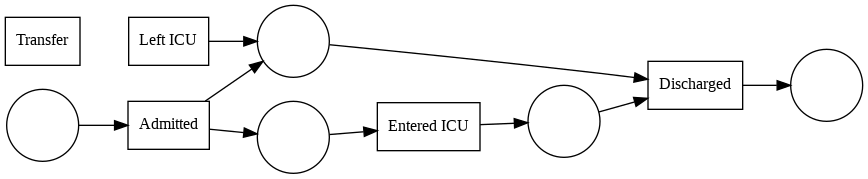

In [56]:
import graphviz
pm.view_petri_net(petri_net=net)

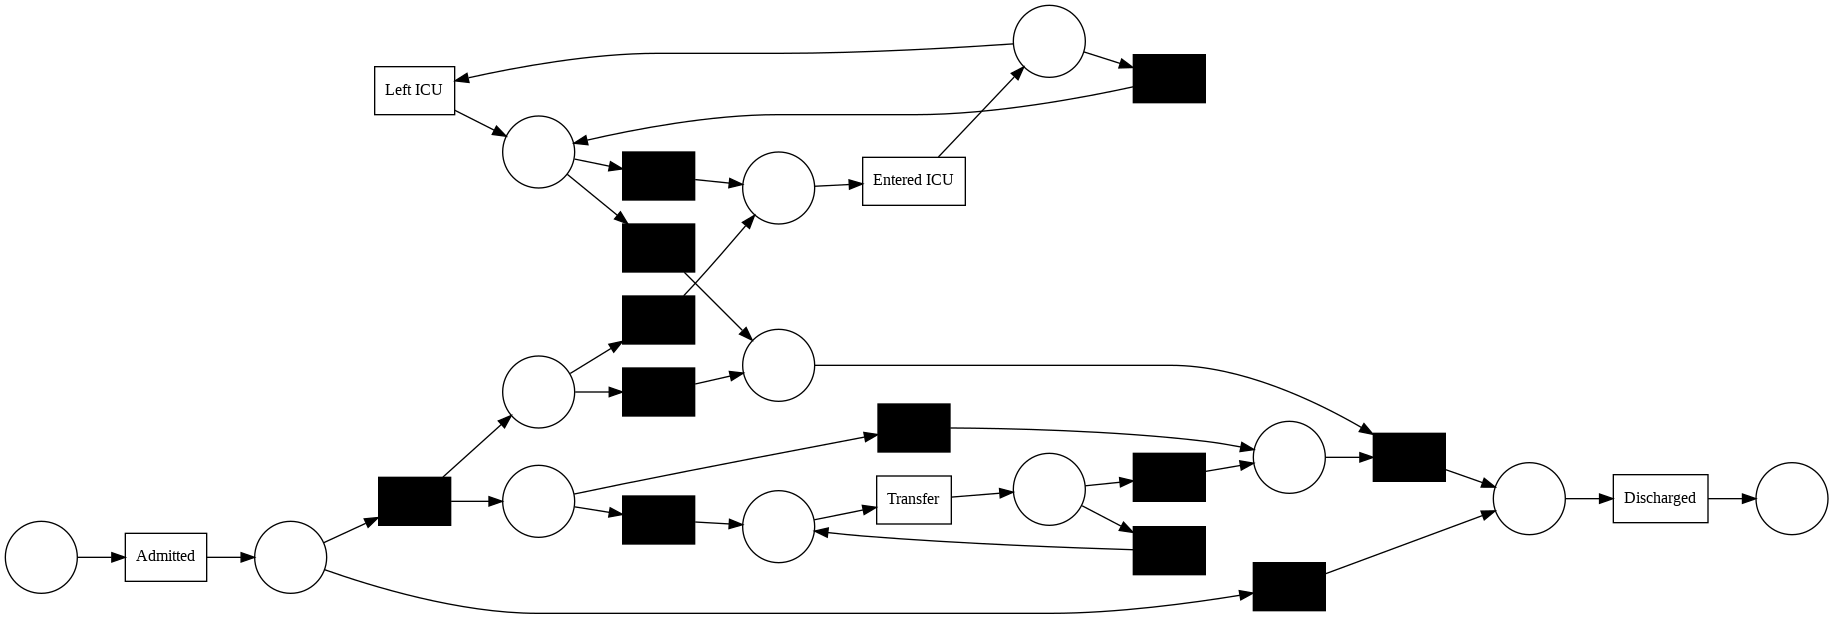

In [57]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

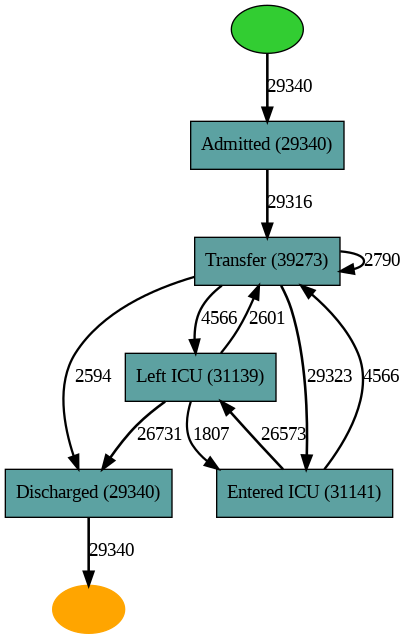

In [58]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

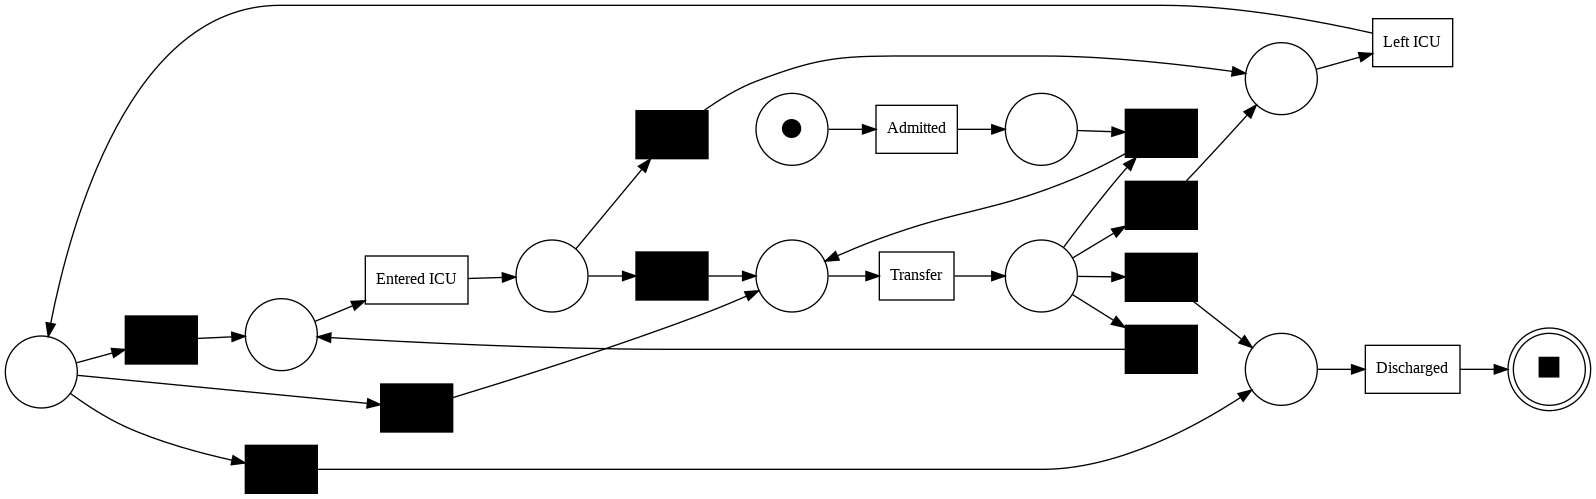

In [59]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

##Section 3: Preprocessing Data

In [60]:
from pandas.core.window.ewm import partial
import random

def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  # random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = el[el['trace'].isin(random_traces)]
  return partial_el


In [61]:
partial_el = partial_log(event_log, NUM_TRACES)
partial_el

,trace,activity,timestamp
2617,477,Admitted,2109-02-14 18:55:00
2618,477,Transfer,2109-02-14 18:56:31
2619,477,Entered ICU,2109-02-15 15:08:15
2620,477,Left ICU,2109-02-17 18:38:01
2621,477,Discharged,2109-02-20 15:30:00
...,...,...,...
154223,28242,Admitted,2103-12-02 13:14:00
154224,28242,Transfer,2103-12-02 13:15:19
154225,28242,Entered ICU,2103-12-02 13:46:05
154226,28242,Left ICU,2103-12-04 18:20:30


In [62]:
from sklearn.model_selection import train_test_split
# select train and test traces
unique_traces = partial_el['trace'].unique()
train_traces, test_traces = train_test_split(unique_traces, test_size=TEST_SIZE, random_state=9)

train_el = partial_el.loc[partial_el['trace'].isin(train_traces)]
test_el = partial_el.loc[partial_el['trace'].isin(test_traces)]
test_el

,trace,activity,timestamp
6107,1109,Admitted,2140-09-21 15:33:00
6108,1109,Transfer,2140-09-21 15:34:35
6109,1109,Entered ICU,2140-09-21 15:34:35
6110,1109,Left ICU,2140-10-02 02:16:28
6111,1109,Discharged,2140-10-11 20:00:00
...,...,...,...
142030,26009,Transfer,2105-04-05 23:49:22
142031,26009,Entered ICU,2105-04-05 23:49:22
142032,26009,Left ICU,2105-04-07 20:39:15
142033,26009,Transfer,2105-04-08 11:06:52


In [63]:
import numpy as np
from copy import deepcopy

def random_remove(el):
  unique_traces_test = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces_test}
  df = pd.DataFrame(columns=['trace', 'activity', 'timestamp'])
  random.seed = (9)
  targets = []

  for t in unique_traces_test:
    traces[t] = deepcopy(test_el[:][test_el.trace == t])
    trace_df = traces[t].sort_values(by='timestamp')
    rand_index = random.randrange(0,len(trace_df.index))
    targets.append(trace_df.iat[rand_index,2])
    trace_df.iat[rand_index, 2] = np.nan
    df = pd.concat([df, trace_df])
    print(df)

  return df, targets

In [64]:
test_x, test_y = random_remove(test_el)
test_x

     trace     activity           timestamp
6107  1109     Admitted 2140-09-21 15:33:00
6108  1109     Transfer 2140-09-21 15:34:35
6109  1109  Entered ICU 2140-09-21 15:34:35
6110  1109     Left ICU                 NaT
6111  1109   Discharged 2140-10-11 20:00:00
      trace     activity           timestamp
6107   1109     Admitted 2140-09-21 15:33:00
6108   1109     Transfer 2140-09-21 15:34:35
6109   1109  Entered ICU 2140-09-21 15:34:35
6110   1109     Left ICU                 NaT
6111   1109   Discharged 2140-10-11 20:00:00
13267  2423     Admitted 2114-01-29 12:56:00
13268  2423     Transfer                 NaT
13269  2423  Entered ICU 2114-01-29 12:57:13
13270  2423     Left ICU 2114-02-01 14:50:30
13271  2423   Discharged 2114-02-06 19:20:00
      trace     activity           timestamp
6107   1109     Admitted 2140-09-21 15:33:00
6108   1109     Transfer 2140-09-21 15:34:35
6109   1109  Entered ICU 2140-09-21 15:34:35
6110   1109     Left ICU                 NaT
6111   1109   Di

,trace,activity,timestamp
6107,1109,Admitted,2140-09-21 15:33:00
6108,1109,Transfer,2140-09-21 15:34:35
6109,1109,Entered ICU,2140-09-21 15:34:35
6110,1109,Left ICU,NaT
6111,1109,Discharged,2140-10-11 20:00:00
...,...,...,...
142030,26009,Transfer,2105-04-05 23:49:22
142031,26009,Entered ICU,NaT
142032,26009,Left ICU,2105-04-07 20:39:15
142033,26009,Transfer,2105-04-08 11:06:52


##Section 4: Predicting the correct sequence order

###4.1 Creating process model using training set

<ipython-input-65-86889e4b3d88>:2: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  train_log = pm.format_dataframe(train_el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

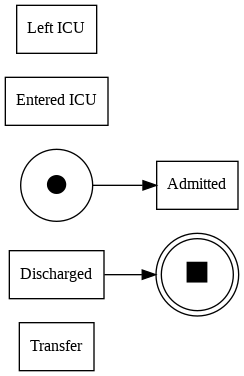

In [65]:
# format train event log as pm4py event log
train_log = pm.format_dataframe(train_el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
# petri net from heuristics miner
heuristic_net, heuristic_im, heuristic_fm = pm.discover_petri_net_heuristics(train_log, dependency_threshold=0.99)
pm.view_petri_net(heuristic_net, heuristic_im, heuristic_fm)

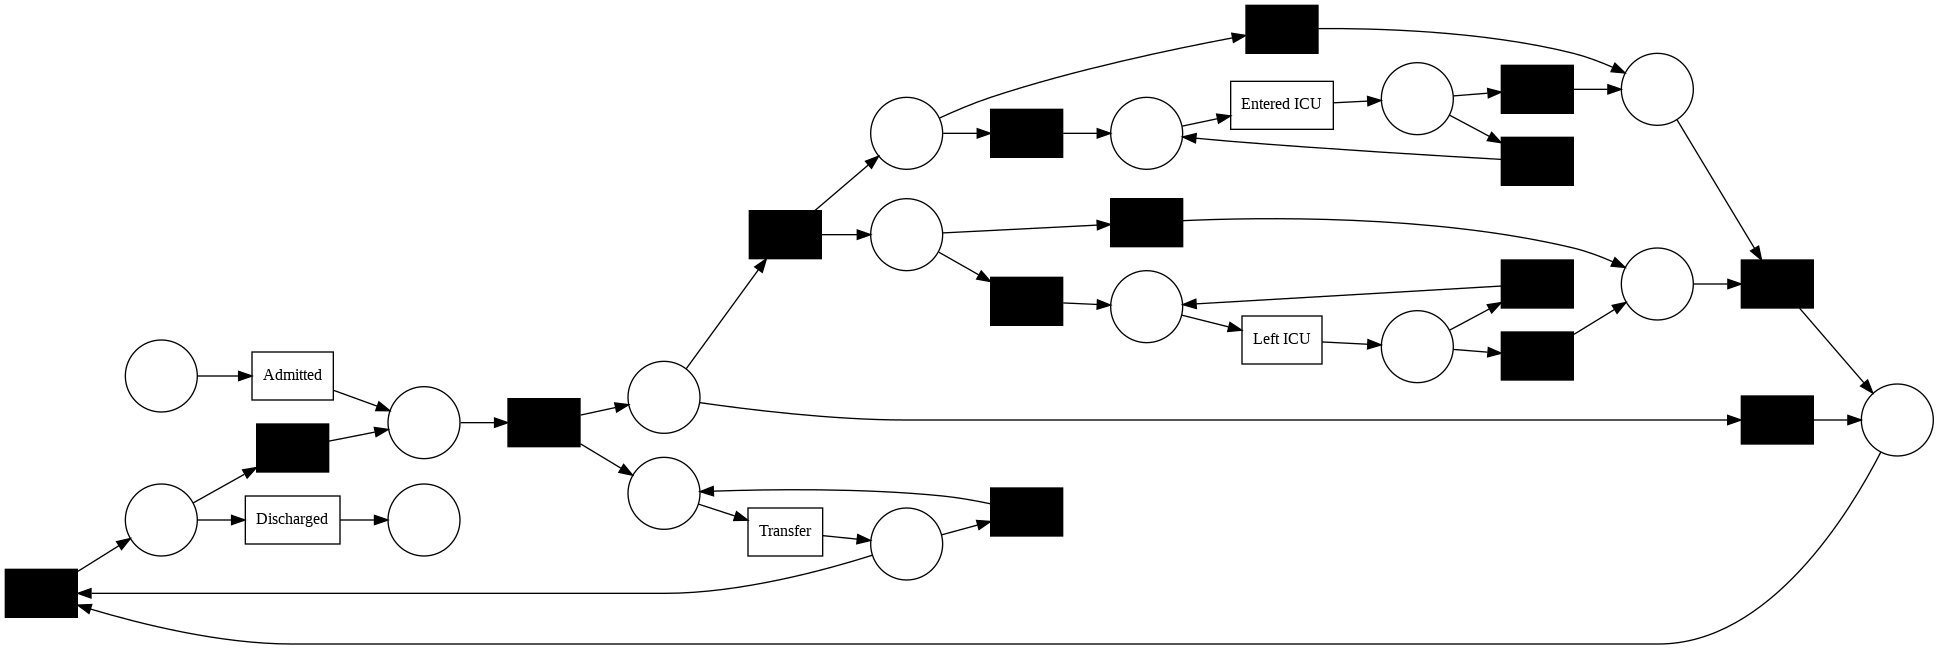

In [66]:
inductive_net, inductive_im, inductive_fm = pm.discover_petri_net_inductive(train_log)
pm.view_petri_net(petri_net=inductive_net)

###4.2

In [67]:
def replay_trace(el):
  pass

In [70]:
def generate_traces(sequence, missing, trace):
    timestamps = sequence['timestamp'].tolist()
    if missing.iat[0,1] == 'Admitted':
      return pd.concat([missing,sequence], ignore_index=True)
    if missing.iat[0,1] == 'Discharged':
      return pd.concat([sequence,missing], ignore_index=True)
     
    # else generate permutations
    trace_length = len(timestamps) -1
    fitness = []
    for i in range(1,trace_length):
      print('permutation: ',i)
      df = pd.concat([sequence.head(i), missing, sequence.tail(trace_length-i)])
      fitness.append(replay_trace(df))

    # for t in len 

    return -1


In [75]:
def predict_sequences(el):
  df = pd.DataFrame(columns=['prefix', 'suffix', 'prefix deltas', 'suffix deltas', 'label'])
  unique_traces = el['trace'].unique()

  for t in unique_traces:
    trace_df = el[:][test_el.trace == t]
    sequence = trace_df.loc[trace_df['timestamp'].notna()]
    missing = trace_df.loc[trace_df['timestamp'].isna()]

    
    predicted_trace = generate_traces(sequence, missing, t)
    # df = pd.concat([df,predicted_trace])


  
  return df

predict_sequences(test_x)


permutation:  1
     trace     activity           timestamp
6107  1109     Admitted 2140-09-21 15:33:00
6110  1109     Left ICU                 NaT
6109  1109  Entered ICU 2140-09-21 15:34:35
6111  1109   Discharged 2140-10-11 20:00:00
permutation:  2
     trace    activity           timestamp
6107  1109    Admitted 2140-09-21 15:33:00
6108  1109    Transfer 2140-09-21 15:34:35
6110  1109    Left ICU                 NaT
6111  1109  Discharged 2140-10-11 20:00:00
permutation:  1
      trace    activity           timestamp
13267  2423    Admitted 2114-01-29 12:56:00
13268  2423    Transfer                 NaT
13270  2423    Left ICU 2114-02-01 14:50:30
13271  2423  Discharged 2114-02-06 19:20:00
permutation:  2
      trace     activity           timestamp
13267  2423     Admitted 2114-01-29 12:56:00
13269  2423  Entered ICU 2114-01-29 12:57:13
13268  2423     Transfer                 NaT
13271  2423   Discharged 2114-02-06 19:20:00
permutation:  1
      trace    activity           timest

,prefix,suffix,prefix deltas,suffix deltas,label


In [ ]:
test_x

,trace,activity,timestamp
3448,626,Admitted,2116-07-19 21:07:00
3449,626,Transfer,2116-07-19 21:08:10
3450,626,Entered ICU,NaT
3451,626,Left ICU,2116-07-20 21:24:56
3452,626,Discharged,2116-07-22 16:00:00
...,...,...,...
155128,28406,Transfer,2174-01-28 05:57:53
155129,28406,Entered ICU,2174-01-28 05:57:53
155130,28406,Left ICU,NaT
155131,28406,Transfer,2174-02-03 14:43:42
